In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sunpy
import math
import numpy as np
from sunpy.coordinates.sun import carrington_rotation_number
from scipy.spatial import distance

In [3]:
import warnings
warnings.filterwarnings('ignore')

Greenwich data from: https://solarscience.msfc.nasa.gov/greenwch.shtml \
Zurich data from: https://github.com/observethesun/zurich_catalogs

In [2]:
import glob
dfs = []
for fin in glob.glob('greenwich/*.txt'):
    dfs.append(pd.read_csv(fin, header = None))
greenwich = pd.concat(dfs)

dfs = []
for fin in glob.glob('Digitized_*.csv'):
    dfs.append(pd.read_csv(fin))
dig = pd.concat(dfs, ignore_index=True)

In [4]:
def is_float(element: any) -> bool:
    #If you expect None to be passed:
    if element is None: 
        return False
    try:
        float(element)
        return True
    except ValueError:
        return False

In [5]:
dig = dig.loc[dig["Object"] == 'Sunspot']
dig['Date'] = pd.to_datetime(dig['Date'])
dig["CR"] = carrington_rotation_number(dig.loc[:, "Date"])
dig = dig.dropna()
    
greenwich["year"] = greenwich[0].str.slice(stop = 4).astype(int)
greenwich["month"] = greenwich[0].str.slice(start = 4, stop = 6).astype(int)
greenwich["day"] = greenwich[0].str.slice(start = 6, stop = 8).astype(int)
greenwich["Greenwich sunspot group"] = greenwich[0].str.slice(start = 12, stop = 20).apply(lambda x: int(x) 
    if (x.replace(" ","").isnumeric()) else None)
greenwich["CLongtitude"] = greenwich[0].str.slice(start = 57, stop = 62).apply(lambda x: float(x) 
    if is_float(x.replace(" ","")) else None).astype(float)
greenwich["Latitude"] = greenwich[0].str.slice(start = 63, stop = 68).apply(lambda x: float(x) 
    if is_float(x.replace(" ","")) else None).astype(float)
greenwich["Date"] = pd.to_datetime(greenwich[0].str.slice(stop = 4) + "-" + greenwich["month"].astype(str) + "-" + greenwich["day"].astype(str))
greenwich["CR"] = carrington_rotation_number(greenwich.loc[:, "Date"])
greenwich = greenwich.dropna().reset_index(drop=True)

In [6]:
def new_metric(x, y):
    dist = math.sqrt(min(abs(x[0] - y[0]), abs(360 - max(x[0],y[0]) + min(x[0],y[0]))) ** 2 + (y[1] - x[1]) ** 2)
    return dist

def close_points(x, a = -0.78932204, b = 6.62623414):
    return  1/(1 + np.exp(-(a*x +b)))

def find_id(X, y):
    dist = distance.cdist(X, y, metric=new_metric)
    
    return np.argmin(dist)


def algorithm(X, C, cl_numbers):
    """
    X - точки
    C - центры групп
    
    points - номера кластеров для каждой точки
    rankings - величина R для каждой точки Х
    """
    Y = C.copy()
    X2 = X.copy()
    points =  np.full(X.shape[0], -1)
    rankings = np.zeros(C.shape[0] + X.shape[0])
    rankings[:C.shape[0]] = 1
    
    # Восстановление позиции в X
    positions = np.arange(X.shape[0])
    por = np.full(X.shape[0], -1)
    
    for it in range(X.shape[0]):
        dist = distance.cdist(X, Y, metric=new_metric)
        pr = close_points(dist)

        pr *= np.append(rankings[:C.shape[0]], rankings[por[:it] + C.shape[0]])
        k = np.argmax(pr)
        i, j = k // pr.shape[1], k % pr.shape[1]
        
        if (j < C.shape[0]):
            points[positions[i]] = cl_numbers[j]
        else:
            points[positions[i]] = points[por[j - C.shape[0]]]   
            
        Y = np.append(Y, X[i][None, :], axis=0)
        por[it] = find_id(X2, X[i].reshape(1, 2))
        rankings[positions[i] + C.shape[0]] = np.max(pr)
        X = np.delete(X, i, axis=0)
        positions = np.delete(positions, i)
    return points, rankings

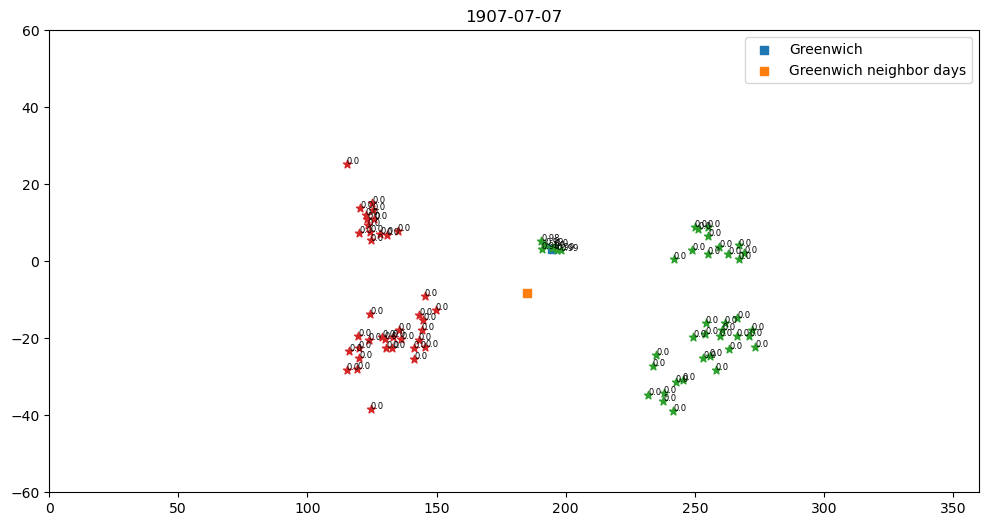

In [8]:
date = pd.to_datetime("1907-07-07")

fig, axs = plt.subplots(1, 1, figsize=(12, 6))
day_gr = greenwich.loc[greenwich["Date"] == date]
axs.scatter(day_gr["CLongtitude"], day_gr["Latitude"], marker = 's', label = "Greenwich")
day = dig.loc[dig["Date"] == date].dropna()
if (day.shape[0] == 0):
    raise Exception('No data')

s = list(day_gr["Greenwich sunspot group"])
indexes = []

for key, value in greenwich.loc[greenwich["Date"] == date + pd.Timedelta("1 day")]["Greenwich sunspot group"].items():
    if value not in s:
        indexes.append(key)

for key, value in greenwich.loc[greenwich["Date"] == date - pd.Timedelta("1 day")]["Greenwich sunspot group"].items():
    if value not in s:
        indexes.append(key)
day_gr = pd.concat([day_gr, greenwich.iloc[indexes]])
axs.scatter(greenwich.iloc[indexes]["CLongtitude"], greenwich.iloc[indexes]["Latitude"], marker = 's', label = "Greenwich neighbor days")

    
day.loc[:, "Column_6"] -= (68.70553089 - 0.08209453 * (date -  pd.to_datetime("1880-01-01")).days) % 360
day.loc[:, "Column_6"]  = day.loc[:, "Column_6"].apply(lambda x: x + 360 if (x < 0) else x)
points, rankings = algorithm(day.loc[:, ["Column_6", "Column_4"]].to_numpy(), 
                             day_gr.loc[:, ["CLongtitude", "Latitude"]].to_numpy(),
                            day_gr.loc[:, ["Greenwich sunspot group"]].to_numpy())

rankings = np.round_(rankings[day_gr.shape[0]:], 2)
day.loc[:, "clusters"] = -1
day.loc[:, "rankings"] = -1

for i in range(day.shape[0]):
    day.iloc[i, [22]] = points[i]
    day.iloc[i, [23]] = rankings[i]

for key, n in enumerate(day["clusters"].unique()):
    group = day.loc[day["clusters"] == n]
    axs.scatter(group["Column_6"], group["Column_4"], marker = '*')
    for i in range(group.shape[0]):
        x = group.loc[:, "Column_6"].iloc[i]
        y = group.loc[:, "Column_4"].iloc[i]
        axs.annotate(group.iloc[i].rankings, (x, y), fontsize=6)


axs.set_ylim(-60, 60)
axs.set_xlim(0, 360)
plt.title(date.date())
plt.legend()
plt.show()

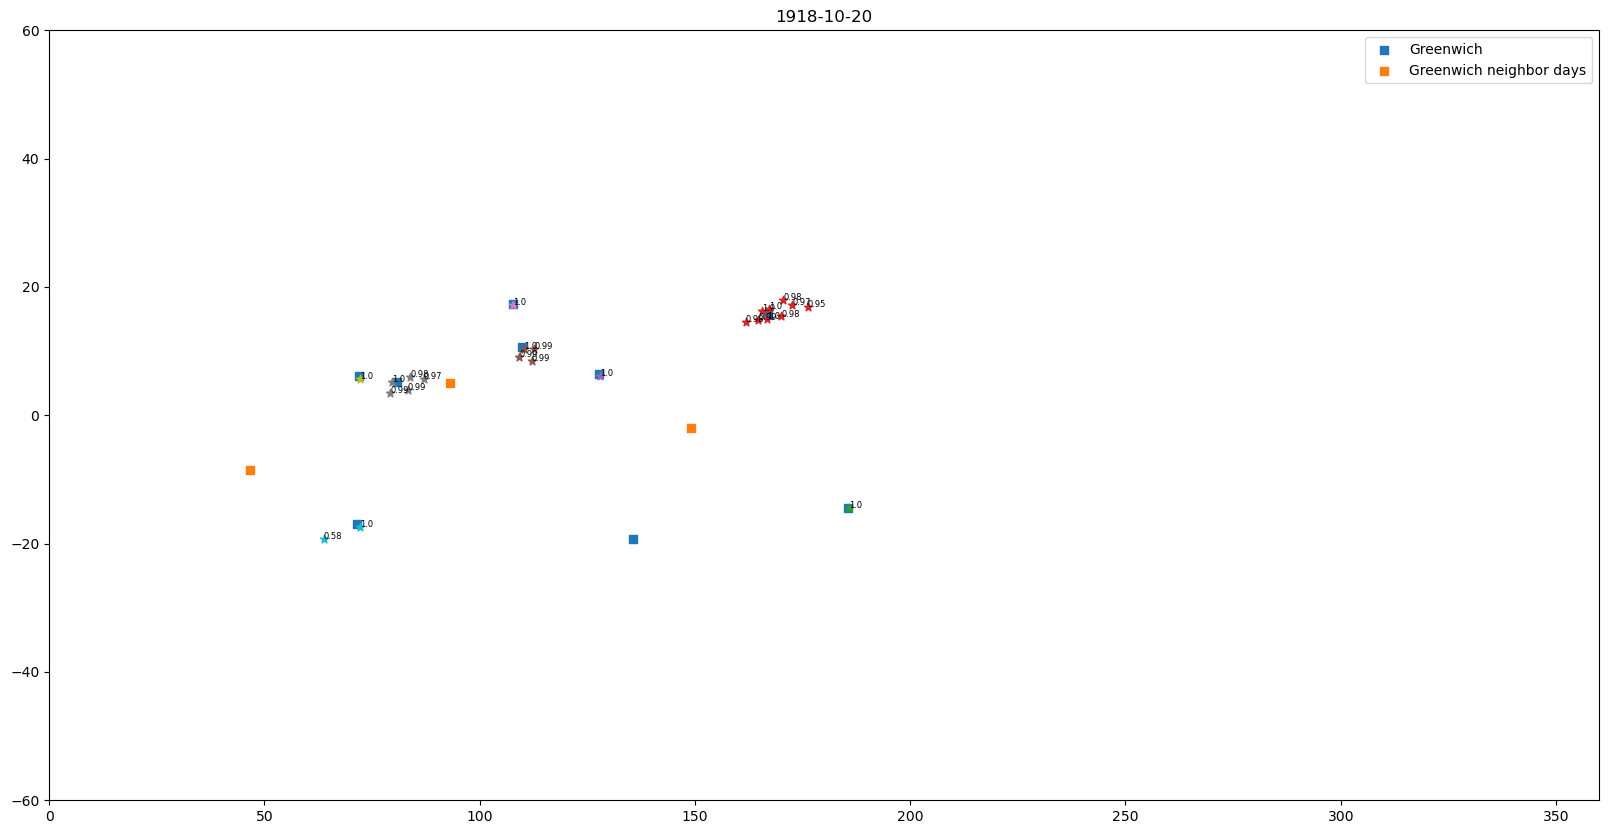

In [22]:
date = pd.to_datetime("1918-10-20")

fig, axs = plt.subplots(1, 1, figsize=(20, 10))
day_gr = greenwich.loc[greenwich["Date"] == date]
axs.scatter(day_gr["CLongtitude"], day_gr["Latitude"], marker = 's', label = "Greenwich")
day = dig.loc[dig["Date"] == date].dropna()
if (day.shape[0] == 0):
    raise Exception('No data')

s = list(day_gr["Greenwich sunspot group"])
indexes = []

for key, value in greenwich.loc[greenwich["Date"] == date + pd.Timedelta("1 day")]["Greenwich sunspot group"].items():
    if value not in s:
        indexes.append(key)

for key, value in greenwich.loc[greenwich["Date"] == date - pd.Timedelta("1 day")]["Greenwich sunspot group"].items():
    if value not in s:
        indexes.append(key)
day_gr = pd.concat([day_gr, greenwich.iloc[indexes]])
axs.scatter(greenwich.iloc[indexes]["CLongtitude"], greenwich.iloc[indexes]["Latitude"], marker = 's', label = "Greenwich neighbor days")

    
day.loc[:, "Column_6"] -= (68.70553089 - 0.08209453 * (date -  pd.to_datetime("1880-01-01")).days) % 360
day.loc[:, "Column_6"]  = day.loc[:, "Column_6"].apply(lambda x: x + 360 if (x < 0) else x)
points, rankings = algorithm(day.loc[:, ["Column_6", "Column_4"]].to_numpy(), 
                             day_gr.loc[:, ["CLongtitude", "Latitude"]].to_numpy(),
                            day_gr.loc[:, ["Greenwich sunspot group"]].to_numpy())

rankings = np.round_(rankings[day_gr.shape[0]:], 2)
day.loc[:, "clusters"] = -1
day.loc[:, "rankings"] = -1

for i in range(day.shape[0]):
    day.iloc[i, [22]] = points[i]
    day.iloc[i, [23]] = rankings[i]

for key, n in enumerate(day["clusters"].unique()):
    group = day.loc[day["clusters"] == n]
    axs.scatter(group["Column_6"], group["Column_4"], marker = '*')
    for i in range(group.shape[0]):
        x = group.loc[:, "Column_6"].iloc[i]
        y = group.loc[:, "Column_4"].iloc[i]
        axs.annotate(group.iloc[i].rankings, (x, y), fontsize=6)


axs.set_ylim(-60, 60)
axs.set_xlim(0, 360)
plt.title(date.date())
plt.legend()
plt.show()